## Nah

In [ ]:
import tensorflow as tf  # I am using tensorflow=2.1
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
import numpy as np
import os
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(2)

In [3]:
class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config

class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        self.use_bias = False
        self.kernel_regularizer = None
        self.stride = 1
        if 'use_bias' in conv_kwargs:
            self.use_bias = conv_kwargs['use_bias']
        if 'kernel_regularizer' in conv_kwargs:
            self.kernel_regularizer = conv_kwargs['kernel_regularizer']
        if 'stride' in conv_kwargs:
            self.stride = conv_kwargs['stride']

        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        #self.conv = Conv2D(
        #    #filters, kernel_size, padding='valid', **conv_kwargs
        #)
        #self.transpose_conv=Conv2DTranspose(
        #    #filters, kernel_size, padding='valid', **conv_kwargs
        #)

    def call(self, inputs):
        paddinginputs = self.padding(inputs)
        inputshape = paddinginputs.get_shape()
        weight = tf.compat.v1.get_variable(name = 'weights', shape=[self.kernel_size,self.kernel_size,inputshape[-1],self.filters], initializer = tf.keras.initializers.glorot_normal, regularizer=self.kernel_regularizer)
        conv = tf.nn.conv2d(paddinginputs, weight, strides=self.stride,padding='VALID')
        paddinginput_back = conv
        if self.use_bias:
            bias = tf.compat.v1.get_variable(name = 'bias', shape=[self.filters], initializer = tf.keras.initializers.glorot_normal)
            conv += bias
        paddinginput_back = tf.nn.conv2d_transpose(paddinginput_back, weight,tf.shape(paddinginputs), self.stride, padding = 'VALID')
        rrloss = tf.reduce_mean(tf.nn.l2_loss(paddinginputs - paddinginput_back))
        return conv, rrloss

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

def convblock(inputs, filters, kernel=3, stride=1, bn_position=None, l2=0,
              use_bias=True, dropout=0, activation='relu'):
    x = inputs
    if bn_position == 'pre': x = BatchNormalization()(x)
    x, rrloss_p = PeriodicConv2D(
        filters,  kernel, conv_kwargs={
            'kernel_regularizer': regularizers.l2(l2),
            'use_bias': use_bias,
        }
    )(x)
    if bn_position == 'mid': x = BatchNormalization()(x)
    x = LeakyReLU()(x) if activation == 'leakyrelu' else Activation(activation)(x)
    if bn_position == 'post': x = BatchNormalization()(x)
    if dropout > 0: x = Dropout(dropout)(x)
    return x, rrloss_p

def resblock(inputs, filters, kernel, bn_position=None, l2=0, use_bias=True,
             dropout=0, skip=True, activation='relu', down=False, up=False):
    rrloss = tf.constant(0.)
    x = inputs
    if down:
        x = MaxPooling2D()(x)
    for i in range(2):
        with tf.compat.v1.variable_scope("reslayer_%d"%i):
            x, rrloss_p = convblock(
                x, filters, kernel, bn_position=bn_position, l2=l2, use_bias=use_bias,
                dropout=dropout, activation=activation
            )
            rrloss += rrloss_p
    if down or up:
        with tf.compat.v1.variable_scope("reslayer_%s"%("down" if down else "up")):
            inputs, rrloss_p = PeriodicConv2D(
                filters,  kernel, conv_kwargs={
                    'kernel_regularizer': regularizers.l2(l2),
                    'use_bias': use_bias,
                    'strides': 2 if down else 1
                }
            )(inputs)
            rrloss += rrloss_p
    if skip: x = Add()([inputs, x])
    return x, rrloss

#def build_resnet(input, filters, kernels, input_shape, bn_position=None, use_bias=True, l2=0,
def build_resnet(input, filters, kernels, bn_position=None, use_bias=True, l2=0,
                 skip=True, dropout=0, activation='relu', long_skip=False,
                 **kwargs):
    x = input# = Input(shape=input_shape)
    rrloss = tf.constant(0.)

    # First conv block to get up to shape
    with tf.compat.v1.variable_scope("head"):
        x, rrloss_p = convblock(
            x, filters[0], kernels[0], bn_position=bn_position, l2=l2, use_bias=use_bias,
            dropout=dropout, activation=activation
        )
        rrloss += rrloss_p
        ls = x

    # Resblocks
    layerindex = 0
    for f, k in zip(filters[1:-1], kernels[1:-1]):
        with tf.compat.v1.variable_scope("resblock_%d"%layerindex):
            x, rrloss_p = resblock(x, f, k, bn_position=bn_position, l2=l2, use_bias=use_bias,
                    dropout=dropout, skip=skip, activation=activation)
            rrloss += rrloss_p
            if long_skip:
                x = Add()([x, ls])
        layerindex += 1

    with tf.compat.v1.variable_scope("end"):
        # Final convolution
        output, rrloss_p = PeriodicConv2D(
            filters[-1], kernels[-1],
            conv_kwargs={'kernel_regularizer': regularizers.l2(l2)},
        )(x)
        rrloss += rrloss_p

    # This is just because I am using mixed precision. Can be left out for regular precision.
    output = Activation('linear', dtype='float32')(output)
    #return keras.models.Model(input, output), rrloss
    return output, rrloss

In [4]:
args = load_args('../nn_configs/C/017-resnet_d3_ztt_3d.yml')
args['train_years'] = ['2015', '2015']
args['valid_years'] = ['2015', '2015']
args['test_years'] = ['2015', '2015']
args['train_tfr_files'] = None
args['test_tfr_files'] = None
args['tvalid_tfr_files'] = None

In [5]:
dg_test = load_data(**args, only_test=True)

In [7]:
inputs = Input(shape=dg_test.shape)

In [9]:
output, rrloss = build_resnet(
    inputs,
    filters=[128, 128, 128, 3],
    kernels=[7, 3, 3, 3],
    #input_shape=(32, 64, 114,),
    bn_position='post',
    dropout=0.1,   # I am currently using a combination of dropout and l2 for regularization
    l2=1e-5,       # Of course it would be great if I didn't have to use them with racecar
    activation='leakyrelu',
)

## Pre for You

In [1]:
import re
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import xarray as xr
import datetime
import pandas as pd
import pdb
from tqdm import tqdm

In [9]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True,
                 mean=None, std=None, output_vars=None, data_subsample=1, norm_subsample=1,
                 nt_in=1, dt_in=1, cont_time=False, fixed_time=False, multi_dt=1, verbose=0,
                 min_lead_time=None, las_kernel=None, las_gauss_std=None, normalize=True,
                 tfrecord_files=None, tfr_buffer_size=1000, tfr_num_parallel_calls=1,
                 cont_dt=1, tfr_prefetch=None, tfr_repeat=True, y_roll=None, X_roll=None,
                 discard_first=None, tp_log=None, tfr_out=False, tfr_out_idxs=None,
                 old_const=False, is_categorical=False, num_bins=50, bin_min=-5, bin_max=5,
                 predict_difference=False, adaptive_bins=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
            data_subsample: Only take every ith time step
            norm_subsample: Same for normalization. This is AFTER data_subsample!
            nt_in: How many time steps for input. AFTER data_subsample!
            dt_in: Interval of input time steps. AFTER data_subsample!
        """
        if verbose: print('DG start', datetime.datetime.now().time())
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time
        self.nt_in = nt_in
        self.dt_in = dt_in
        self.cont_time = cont_time
        self.min_lead_time = min_lead_time
        self.fixed_time = fixed_time
        self.multi_dt = multi_dt
        self.tfrecord_files = tfrecord_files
        self.normalize = normalize
        self.tfr_num_parallel_calls = tfr_num_parallel_calls
        self.tfr_buffer_size = tfr_buffer_size
        self.cont_dt = cont_dt
        self.tfr_prefetch = tfr_prefetch
        self.tfr_repeat = tfr_repeat
        self.tfr_out = tfr_out
        self.y_roll = y_roll
        self.X_roll = X_roll
        self.tfr_max_lead = 120
        self.tfr_out_idxs = tfr_out_idxs
        self.old_const = old_const
        self.is_categorical = is_categorical
        self.num_bins = num_bins
        self.bin_min = bin_min
        self.bin_max = bin_max
        self.predict_difference = predict_difference
        if self.predict_difference:
            assert self.tfrecord_files is None, 'difference does not work for tfr'
        self.adaptive_bins = adaptive_bins

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants':
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                da = ds[var]
                if tp_log and var == 'tp':
                    da = log_trans(da, tp_log)
                try:
                    data.append(da.sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(da.expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        if discard_first is not None:
            self.data = self.data.isel(time=slice(discard_first, None))
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(self.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values)
                                if any([bool(re.match(o, l)) for o in output_vars])]
        self.const_idxs = [i for i, l in enumerate(self.data.level_names) if l in var_dict['constants']]
        self.not_const_idxs = [i for i, l in enumerate(self.data.level_names) if l not in var_dict['constants']]

        # Subsample
        self.data = self.data.isel(time=slice(0, None, data_subsample))
        self.raw_data = self.data
        self.dt = self.data.time.diff('time')[0].values / np.timedelta64(1, 'h')
        self.dt_in = int(self.dt_in // self.dt)
        self.nt_offset = (nt_in - 1) * self.dt_in

        if self.min_lead_time is None:
            self.min_nt = 1
        else:
            self.min_nt = int(self.min_lead_time / self.dt)

        # Normalize
        if verbose: print('DG normalize', datetime.datetime.now().time())
        if mean is not None:
            self.mean = mean
        else:
            self.mean = self.data.isel(time=slice(0, None, norm_subsample)).mean(
                ('time', 'lat', 'lon')).compute()
            if 'tp' in self.data.level_names:  # set tp mean to zero but not if ext
                tp_idx = list(self.data.level_names).index('tp')
                self.mean.values[tp_idx] = 0

        if std is not None:
            self.std = std
        else:
            self.std = self.data.isel(time=slice(0, None, norm_subsample)).std(
                ('time', 'lat', 'lon')).compute()
        if tp_log is not None:
            self.mean.attrs['tp_log'] = tp_log
            self.std.attrs['tp_log'] = tp_log
        if normalize:
            self.data = (self.data - self.mean) / self.std

        if verbose: print('DG load', datetime.datetime.now().time())
        if load:
            if verbose: print('Loading data into RAM')
            self.data.load()
        if verbose: print('DG done', datetime.datetime.now().time())

        if self.X_roll is not None:
            self.X_roll = int(self.X_roll // self.dt)
            self.X_rolled = self.data.rolling(time=self.X_roll).mean()
            self.nt_offset += self.X_roll

        self.on_epoch_end()

        if self.y_roll is not None:
            self.y_roll = int(self.y_roll // self.dt)
            assert self.y_roll < self.nt, 'nt must be larger than y_roll'
            self.y_rolled = self.data.isel(level=self.output_idxs).rolling(time=self.y_roll).mean()

        if self.tfrecord_files is not None:
            self.is_tfr = True
            self._setup_tfrecord_ds()
        else:
            self.is_tfr = False
            self.tfr_dataset = None

        if self.is_categorical:
            self.bins = np.linspace(self.bin_min, self.bin_max, self.num_bins+1)
            self.bins[0] = -np.inf; self.bins[-1] = np.inf  # for rare out-of-bound cases.

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.nt_offset, self.n_samples)
        if self.shuffle:
            np.random.shuffle(self.idxs)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.idxs) / self.batch_size))
    
    @property
    def shape(self):
        return (
            len(self.data.lat),
            len(self.data.lon),
            len(self.data.level.isel(level=self.not_const_idxs)) * self.nt_in + len(self.data.level.isel(
                level=self.const_idxs)) + self.cont_time
        )

    @property
    def nt(self):
        assert (self.lead_time / self.dt).is_integer(), "lead_time and dt not compatible."
        return int(self.lead_time / self.dt)

    @property
    def init_time(self):
        stop = -self.nt
        if self.is_tfr:
            stop += -(self.tfr_max_lead - self.lead_time // self.dt)
        return self.data.isel(time=slice(self.nt_offset, int(stop))).time

    @property
    def valid_time(self):
        start = self.nt+self.nt_offset
        stop = None
        if self.multi_dt > 1:
            diff = self.nt - self.nt // self.multi_dt
            start -= diff; stop = -diff
        if self.is_tfr:
            stop = -int((self.tfr_max_lead - self.lead_time) // self.dt)
            if stop == 0:
                stop = None
        return self.data.isel(time=slice(start, stop)).time

    @property
    def n_samples(self):
        return self.data.isel(time=slice(0, -self.nt)).shape[0]

    def __getitem__(self, i):
        if self.tfrecord_files is None:
            if hasattr(self, 'cheat'):
                X, y = self._get_item(i)
                return X, y[-1]
            else:
                return self._get_item(i)
        else:
            return self._get_tfrecord_item(i)

    def _get_item(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]

        if self.cont_time:
            if not self.fixed_time:
                nt = np.random.randint(self.min_nt, self.nt + 1, len(idxs))
            else:
                nt = np.ones(len(idxs), dtype='int') * self.nt
            ftime = (nt * self.dt / 100)[:, None, None] * np.ones((1, len(self.data.lat),
                                                                   len(self.data.lon)))
        else:
            nt = self.nt

        if self.X_roll is not None:
            X_data = self.X_rolled
        else:
            X_data = self.data

        X = X_data.isel(time=idxs).values.astype('float32')

        if self.multi_dt > 1: consts = X[..., self.const_idxs]

        if self.nt_in > 1:
            if self.old_const:
                X = np.concatenate([
                                       self.data.isel(time=idxs - nt_in * self.dt_in).values
                                       for nt_in in range(self.nt_in - 1, 0, -1)
                                   ] + [X], axis=-1).astype('float32')
            else:
                X = np.concatenate([
                                       X_data.isel(time=idxs - nt_in * self.dt_in).values[..., self.not_const_idxs]
                                       for nt_in in range(self.nt_in - 1, 0, -1)
                                   ] + [X], axis=-1).astype('float32')

        if self.multi_dt > 1:
            X = [X[..., self.not_const_idxs], consts]
            step = self.nt // self.multi_dt
            y = [
                self.data.isel(time=idxs + nt, level=self.output_idxs).values.astype('float32')
                for nt in np.arange(step, self.nt + step, step)
            ]
        elif self.y_roll is not None:
            y = self.y_rolled.isel(
                time=idxs + nt,
            ).values.astype('float32')
        elif self.tfr_out:
            assert self.batch_size == 1, 'bs must be one'
            time_slice = slice(idxs[0]+self.min_nt, idxs[0]+self.nt+1)
            y = self.data.isel(time=time_slice, level=self.output_idxs).values.astype('float32')[None]
        elif self.predict_difference:
            y = (
                self.data.isel(time=idxs + nt, level=self.output_idxs).values -
                self.data.isel(time=idxs, level=self.output_idxs).values
            ).astype('float32')
        else:
            y = self.data.isel(time=idxs + nt, level=self.output_idxs).values.astype('float32')

        if self.is_categorical:
            y_shape = y.shape
            y = pd.cut(y.reshape(-1), self.bins, labels=False).reshape(y_shape)
            y = tf.keras.utils.to_categorical(y, num_classes=self.num_bins)

        if self.cont_time:
            X = np.concatenate([X, ftime[..., None]], -1).astype('float32')
        return X, y


    def _decode(self, example_proto):
        dic = _parse(example_proto)
        X = tf.io.parse_tensor(dic['X'], np.float32)
        y = tf.io.parse_tensor(dic['y'], np.float32)
        if self.tfr_out_idxs is not None:
            y = tf.gather(y, self.tfr_out_idxs, axis=-1)
        if self.cont_time:
            if self.fixed_time:
                y_idx = self.nt-1
            else:
                y_idx = tf.random.uniform((), self.min_nt-1, self.nt, dtype=tf.int32)
            y_time = (y_idx+1) * self.dt
            ftime = (y_time / 100) * np.ones((len(self.data.lat), len(self.data.lon), 1))
            X = tf.concat([X, tf.cast(ftime, tf.float32)], -1)
            return X, y[y_idx]
        else:
            y_idx = self.nt-1
            return X, y[y_idx]

    def _setup_tfrecord_ds(self):
        # Find all files to be used
        if type(self.tfrecord_files) is list:
            tfr_fns = self.tfrecord_files
        else:
            tfr_fns = sorted(glob(self.tfrecord_files))

        dataset = tf.data.TFRecordDataset(
            tfr_fns, num_parallel_reads=self.tfr_num_parallel_calls
        ).map(self._decode)

        if self.shuffle:
            dataset = dataset.shuffle(
                buffer_size=self.tfr_buffer_size, reshuffle_each_iteration=True
            )

        self.tfr_dataset = dataset.batch(self.batch_size)
        # if self.tfr_repeat:
        #     self.tfr_dataset = self.tfr_dataset.repeat()
        if self.tfr_prefetch is not None:
            self.tfr_dataset = self.tfr_dataset.prefetch(self.tfr_prefetch)
        self.tfr_dataset_np = self.tfr_dataset.as_numpy_iterator()


    def _get_tfrecord_item(self, i):
        X, y = next(self.tfr_dataset_np)
        return X, y

    def to_tfr(self, savedir, steps_per_file=250):
        assert self.batch_size == 1, 'bs must be one'
        for i, (X, y) in tqdm(enumerate(self)):
            if i % steps_per_file == 0:
                c = int(np.floor(i / steps_per_file))
                fn = f'{savedir}/{str(c).zfill(3)}.tfrecord'
                print('Writing to file:', fn)
                writer = tf.io.TFRecordWriter(fn)
            serialized_example = serialize_example(X[0], y[0])  # Remove batch dimension
            writer.write(serialized_example)
            if i + 1 % steps_per_file == 0:
                writer.close()
        writer.close()

In [10]:
datadir = '/data/stephan/WeatherBench/5.625deg/'
var_dict = {
    'geopotential': ('z', [50, 250, 500, 600, 700, 850, 925]), 
    'temperature': ('t', [50, 250, 500, 600, 700, 850, 925]), 
    'u_component_of_wind': ('u', [50, 250, 500, 600, 700, 850, 925]), 
    'v_component_of_wind': ('v', [50, 250, 500, 600, 700, 850, 925]), 
    'specific_humidity': ('q', [50, 250, 500, 600, 700, 850, 925]), 
    'toa_incident_solar_radiation': ('tisr', None), 
    '2m_temperature': ('t2m', None), 
    '6hr_precipitation': ('tp', None), 
    'constants': ['lsm','orography','lat2d']
}
output_vars = ['z_500', 't_850', 't2m']
lead_time = 72
data_subsample = 2
norm_subsample = 30000
nt = 3
dt = 6
discard_first = 24

In [11]:
ds = xr.merge(
    [xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords')
     for var in var_dict.keys()],
    fill_value=0  # For the 'tisr' NaNs
)

In [16]:
train_years = ['1979', '2015']  # For full training data, use ['1979', '2015']. Will use 200GB of RAM.
valid_years = ['2016', '2016']
test_years = ['2017', '2018']
ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*valid_years))
ds_test = ds.sel(time=slice(*test_years))

In [51]:
ds_test.time

<xarray.DataArray 'time' (time: 17520)>
array(['2017-01-01T00:00:00.000000000', '2017-01-01T01:00:00.000000000',
       '2017-01-01T02:00:00.000000000', ..., '2018-12-31T21:00:00.000000000',
       '2018-12-31T22:00:00.000000000', '2018-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Attributes:
    long_name:  time

In [17]:
dg_train = DataGenerator(
    ds_train,
    var_dict,
    lead_time,
    output_vars=output_vars,
    data_subsample=data_subsample,
    norm_subsample=norm_subsample,
    nt_in=nt,
    dt_in=dt,
    discard_first=discard_first
)
dg_valid = DataGenerator(
    ds_valid,
    var_dict,
    lead_time,
    output_vars=output_vars,
    data_subsample=data_subsample,
    norm_subsample=norm_subsample,
    nt_in=nt,
    dt_in=dt,
    discard_first=discard_first,
    mean=dg_train.mean,  # Remember to use same mean and std for normalization
    std=dg_train.std,
    shuffle=False
)

dg_test = DataGenerator(
    ds_test,
    var_dict,
    lead_time,
    output_vars=output_vars,
    data_subsample=data_subsample,
    norm_subsample=norm_subsample,
    nt_in=nt,
    dt_in=dt,
    discard_first=discard_first,
    mean=dg_train.mean,  # Remember to use same mean and std for normalization
    std=dg_train.std,
    shuffle=False
)

In [18]:
len(dg_train)

5067

In [19]:
X, y = dg_train[0]
print(X.shape, y.shape)

(32, 32, 64, 117) (32, 32, 64, 3)


In [20]:
def create_lat_mse(lat):
    weights_lat = np.cos(np.deg2rad(lat)).values
    weights_lat /= weights_lat.mean()
    def lat_mse(y_true, y_pred):
        error = y_true - y_pred
        mse = error**2 * weights_lat[None, : , None, None]
        return mse
    return lat_mse

In [21]:
lat_mse = create_lat_mse(dg_train.data.lat)

## Evaluation

In [22]:
from glob import glob

In [23]:
!ls /home/youxie/Weather/test_0025/test

predict_test_0000.npy  predict_test_0341.png  predict_test_0683.npy
predict_test_0000.png  predict_test_0342.npy  predict_test_0683.png
predict_test_0001.npy  predict_test_0342.png  predict_test_0684.npy
predict_test_0001.png  predict_test_0343.npy  predict_test_0684.png
predict_test_0002.npy  predict_test_0343.png  predict_test_0685.npy
predict_test_0002.png  predict_test_0344.npy  predict_test_0685.png
predict_test_0003.npy  predict_test_0344.png  predict_test_0686.npy
predict_test_0003.png  predict_test_0345.npy  predict_test_0686.png
predict_test_0004.npy  predict_test_0345.png  predict_test_0687.npy
predict_test_0004.png  predict_test_0346.npy  predict_test_0687.png
predict_test_0005.npy  predict_test_0346.png  predict_test_0688.npy
predict_test_0005.png  predict_test_0347.npy  predict_test_0688.png
predict_test_0006.npy  predict_test_0347.png  predict_test_0689.npy
predict_test_0006.png  predict_test_0348.npy  predict_test_0689.png
predict_test_0007.npy  predict_test_0348.png  pr

In [24]:
a = np.load('/home/youxie/Weather/test_0025/test/predict_test_0000.npy')

In [25]:
a.shape

(32, 64, 3)

In [26]:
files = sorted(glob('/home/youxie/Weather/test_0025/test/predict_test*.npy'))

In [27]:
arrs = []
for f in files:
    arrs.append(np.load(f))

In [28]:
preds = np.array(arrs)
preds.shape

(1024, 32, 64, 3)

In [29]:
dg = dg_test

In [30]:
level_names = dg.data.isel(level=dg.output_idxs).level_names
level = dg.data.isel(level=dg.output_idxs).level

In [32]:
mean = dg.mean.isel(level=dg.output_idxs).values
std = dg.std.isel(level=dg.output_idxs).values

In [34]:
valid_time = dg.valid_time[:len(preds)]

In [35]:
preds = xr.DataArray(
    preds,
    dims=['time', 'lat', 'lon', 'level'],
    coords={'time': valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
            'level': level,
            'level_names': level_names
            },
)

In [36]:
preds = preds * std + mean

In [37]:
unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values]))

In [40]:
das = []
for v in unique_vars:
    idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] == v]
    da = preds.isel(level=idxs).squeeze().drop('level_names')
    if not 'level' in da.dims: da = da.drop('level')
    das.append({v: da})
preds =  xr.merge(das)

In [30]:
preds

NameError: name 'preds' is not defined

In [44]:
z500_valid = xr.open_mfdataset(f'{datadir}geopotential_500/*.nc').sel(time=slice('2016', '2018', None)).drop('level')
t850_valid = xr.open_mfdataset(f'{datadir}temperature_850/*.nc').sel(time=slice('2016', '2018', None)).drop('level')
t2m_valid = xr.open_mfdataset(f'{datadir}2m_temperature/*.nc').sel(time=slice('2016', '2018', None))
tp_valid = xr.open_mfdataset(f'{datadir}6hr_precipitation/*.nc').sel(time=slice('2016', '2018', None))

valid = xr.merge([z500_valid, t850_valid, t2m_valid, tp_valid]).load()

In [45]:
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 26304)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2016-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 48835.266 48819.938 ... 48812.22 48728.004
    t        (time, lat, lon) float32 253.01103 253.26419 ... 249.83167
    t2m      (time, lat, lon) float32 243.87555 244.38557 ... 251.94333
    tp       (time, lat, lon) float32 1.0123476e-05 ... 7.4492156e-05

In [46]:
def compute_weighted_rmse(da_fc, da_true, mean_dims=xr.ALL_DIMS):
    """
    Compute the RMSE with latitude weighting from two xr.DataArrays.
    Args:
        da_fc (xr.DataArray): Forecast. Time coordinate must be validation time.
        da_true (xr.DataArray): Truth.
    Returns:
        rmse: Latitude weighted root mean squared error
    """
    error = da_fc - da_true
    weights_lat = np.cos(np.deg2rad(error.lat))
    weights_lat /= weights_lat.mean()
    rmse = np.sqrt(((error)**2 * weights_lat).mean(mean_dims))
    return rmse

In [47]:
compute_weighted_rmse(preds, valid)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 568.4
    t2m      float64 2.714
    t        float64 2.898

In [56]:
time = '2017-01-05T12:00'

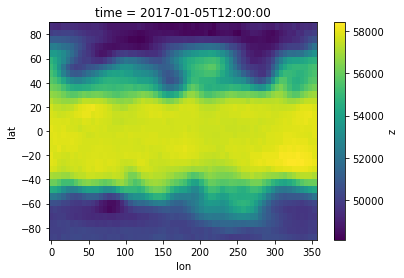

In [59]:
preds.sel(time=time).z.plot()

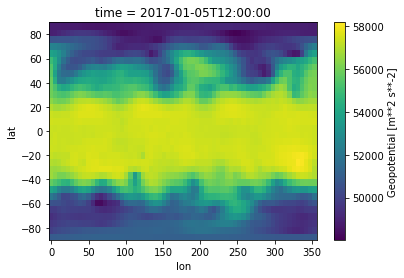

In [60]:
valid.sel(time=time).z.plot()

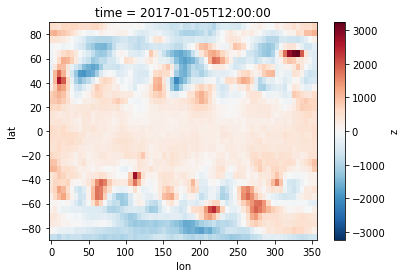

In [61]:
(preds - valid).sel(time=time).z.plot()

## Check valid loss for my trained models

In [2]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(7)
limit_mem()

In [4]:
args = load_args('../nn_configs/C/017-resnet_d3_ztt_3d.yml')
args['train_tfr_files'] = None
args['valid_tfr_files'] = None
args['test_tfr_files'] = None

In [5]:
dg_test = load_data(**args, only_test=True)

In [6]:
model = load_model(args)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

In [8]:
lat_mse = create_lat_mse(dg_test.data.lat)

In [9]:
model.compile('adam', lat_mse)

In [10]:
model.evaluate(dg_test, verbose=1)

545/545 [==============================] - 59s 108ms/step - loss: 0.0099


0.009936556220054626

In [12]:
args['model_save_dir']

'/home/rasp/data/myWeatherBench/predictions_C/saved_models/'

In [32]:
h = read_pickle('/home/rasp/data/myWeatherBench/predictions_C/saved_models/017-resnet_d3_ztt_3d_history.pkl')

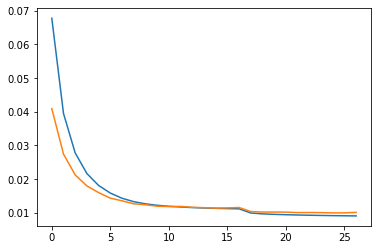

In [34]:
plt.plot(h['loss'][1:])
plt.plot(h['val_loss'][1:])
# plt.yscale('log')

In [35]:
h['loss'][-1], h['val_loss'][-1]

(0.009042072109878063, 0.010096976533532143)

In [36]:
h = read_pickle('/home/rasp/data/myWeatherBench/predictions/saved_models/81.1-resnet_d3_dr_0.1_history.pkl')

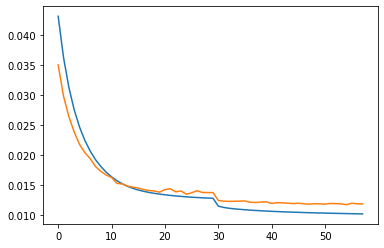

In [37]:
plt.plot(h['loss'][5:])
plt.plot(h['val_loss'][5:])
# plt.yscale('log')

In [38]:
h['loss'][-1], h['val_loss'][-1]

(0.010134964286665249, 0.011805997522425478)

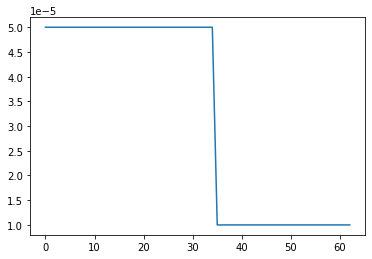

In [39]:
plt.plot(h['lr'])

In [31]:
tf.__version__

'2.2.0'

In [40]:
args

{'my_config': '../nn_configs/C/017-resnet_d3_ztt_3d.yml',
 'datadir': '/data/stephan/WeatherBench/5.625deg/',
 'exp_id': '017-resnet_d3_ztt_3d',
 'model_save_dir': '/home/rasp/data/myWeatherBench/predictions_C/saved_models/',
 'pred_save_dir': '/home/rasp/data/myWeatherBench/predictions_C/',
 'var_dict': {'geopotential': ('z', [50, 250, 500, 600, 700, 850, 925]),
  'temperature': ('t', [50, 250, 500, 600, 700, 850, 925]),
  'u_component_of_wind': ('u', [50, 250, 500, 600, 700, 850, 925]),
  'v_component_of_wind': ('v', [50, 250, 500, 600, 700, 850, 925]),
  'specific_humidity': ('q', [50, 250, 500, 600, 700, 850, 925]),
  'toa_incident_solar_radiation': ('tisr', None),
  '2m_temperature': ('t2m', None),
  '6hr_precipitation': ('tp', None),
  'constants': ['lsm', 'orography', 'lat2d']},
 'output_vars': ['z_500', 't_850', 't2m'],
 'filters': [128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  3],
 'k

In [ ]:
tf.keras.callbacks.ReduceLROnPlateau(
    patience=reduce_lr_patience,
            factor=reduce_lr_factor,
            verbose=1,
            min_lr=reduce_lr_factor**min_lr_times*lr,)